In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

In [2]:
data_path = "ntua-parkinson-dataset-mri"
im_size = 128


In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        shuffle=True,
        image_size=(im_size,im_size),
        batch_size=32)

Found 41235 files belonging to 2 classes.


In [4]:
class_names = data.class_names
class_names

['Non PD Patients', 'PD Patients']

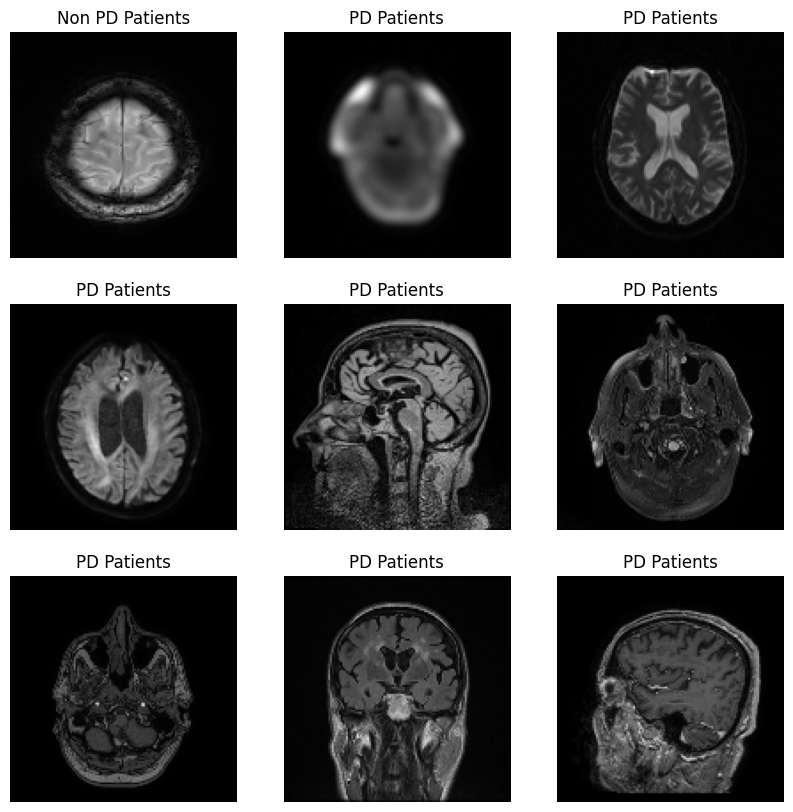

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
train_DataGen = ImageDataGenerator(
                                   rescale = 1./255,
                                   rotation_range = 15,
                                   validation_split = 0.3
                                   )

In [7]:
training_data = train_DataGen.flow_from_directory(
                                                  directory = data_path,
                                                  target_size = (im_size,im_size),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  subset = 'training'
                                                 )

Found 28866 images belonging to 2 classes.


In [8]:
validation_data = train_DataGen.flow_from_directory(
                                                    directory = data_path,
                                                    target_size = (im_size,im_size),
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    subset = 'validation'
                                                   )

Found 12369 images belonging to 2 classes.


In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

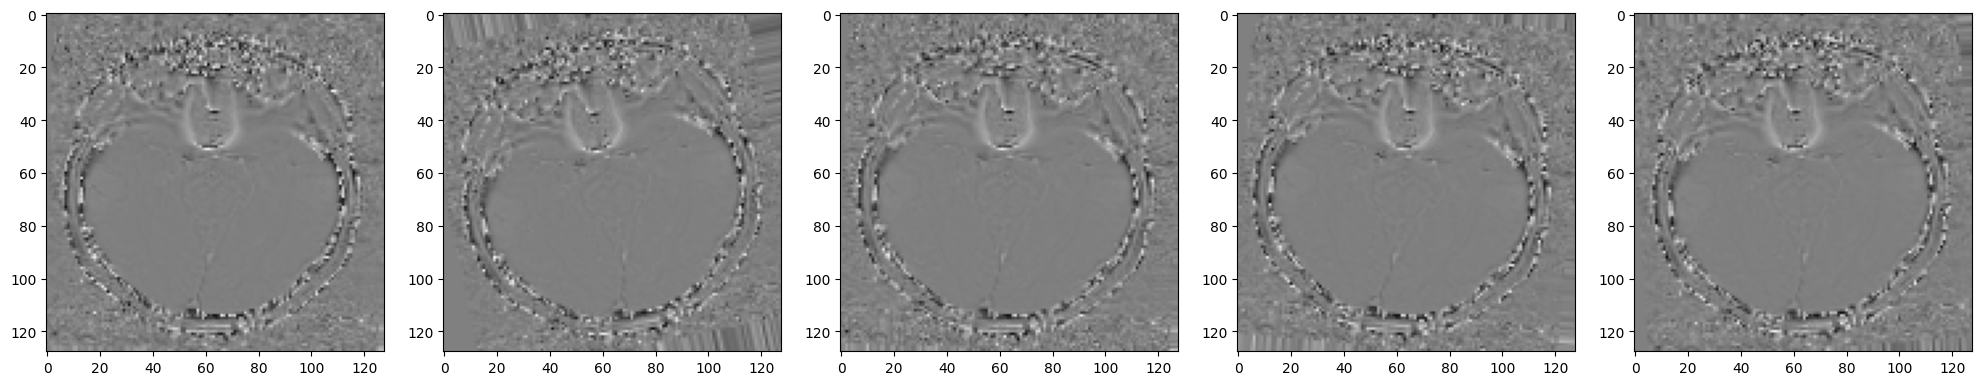

In [10]:
images = [training_data[1][0][0] for i in range(5)]
plotImages(images)

In [11]:
model = Sequential()
model.add(Conv2D(input_shape = (im_size,im_size,3), activation = 'relu', filters = 32, 
                 kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))

# Convolutional layer:
model.add(Conv2D(filters = 128, activation = 'relu', kernel_size = (3,3), strides = (1,1), padding = 'same', 
                 kernel_initializer='he_normal'))

# BatchNormalization:
model.add(BatchNormalization())

# MaxPooling layer:
model.add(MaxPooling2D(pool_size = (2,2)))

# Convolutional layer:
model.add(Conv2D(filters = 256, activation = 'relu', kernel_size = (3,3), strides = (1,1), padding = 'same', 
                 kernel_initializer='he_normal'))

# BatchNormalization:
model.add(BatchNormalization())


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))

# Dense layer:
model.add(Dense(256, activation = 'relu'))

# Dropout layer:
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 64)       256       
 hNormalization)                                                 
                                                        

In [13]:
# compile the model:
model.compile(
              optimizer = Adam(learning_rate= 0.01),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
              )

In [14]:
# Fitting the training data to our model:
history = model.fit(
                              training_data,
                              validation_data = validation_data,
                              epochs = 5,
                              verbose = 1,
                              shuffle = True
                             )

Epoch 1/5
903/903 [==============================] - 1129s 1s/step - loss: 0.5713 - accuracy: 0.7855 - val_loss: 0.5092 - val_accuracy: 0.7932
Epoch 2/5
903/903 [==============================] - 1150s 1s/step - loss: 0.5121 - accuracy: 0.7929 - val_loss: 0.5097 - val_accuracy: 0.7932
Epoch 3/5
903/903 [==============================] - 889s 985ms/step - loss: 0.5112 - accuracy: 0.7931 - val_loss: 0.5146 - val_accuracy: 0.7894
Epoch 4/5
903/903 [==============================] - 884s 979ms/step - loss: 0.5144 - accuracy: 0.7924 - val_loss: 0.5097 - val_accuracy: 0.7932
Epoch 5/5
903/903 [==============================] - 1560s 2s/step - loss: 0.5123 - accuracy: 0.7929 - val_loss: 0.5102 - val_accuracy: 0.7932


In [26]:
model.save("model1")

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


In [27]:
from art.attacks.evasion import FastGradientMethod
import art.estimators.classification
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier

In [34]:
# Disable eager execution in TensorFlow
tf.compat.v1.disable_eager_execution()


In [36]:
# Load the Keras model
classifier = load_model("model1")

# Wrap the Keras model in an ART estimator
estimator = KerasClassifier(model=classifier, clip_values=(0, 1))


In [38]:
# Craft adversarial samples with FGSM
epsilon = 0.1  # Maximum perturbation
adv_crafter = FastGradientMethod(estimator, eps=epsilon)
x_test_adv = adv_crafter.generate(x=validation_data)


MemoryError: Unable to allocate 6.00 MiB for an array with shape (32, 128, 128, 3) and data type float32

In [ ]:
# Evaluate the classifier on the adversarial examples
preds = np.argmax(estimator.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(validation_data, axis=1)) / validation_data.shape[0]
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc * 100))